In [1]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import ExponentialLR

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

SEED = 19
BATCH_SIZE = 64
VAL_SIZE = 0.1
NUM_WORKERS = 0
torch.manual_seed(SEED);

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Current device {DEVICE}')

Current device cuda


### Загрузка данных и исследование размеров изображений

In [3]:
def image_names(path, ext=None):
    paths = []
    if ext is None:
        for folder, subfolders, filenames in os.walk(path):
            for file_name in filenames:
                paths.append(file_name)
    else:
        for folder, subfolders, filenames in os.walk(path):
            for file_name in filenames:
                if file_name.split('.')[-1] == ext:
                    paths.append(file_name) 
                    
    return paths

train_path = './train/'
test_path = './test/'
train_imgs = image_names(train_path, "jpeg")
test_imgs = image_names(test_path, "jpeg")
        
print(f'Images. Train number: {len(train_imgs)}. Test number: {len(test_imgs)}')

Images. Train number: 45373. Test number: 19446


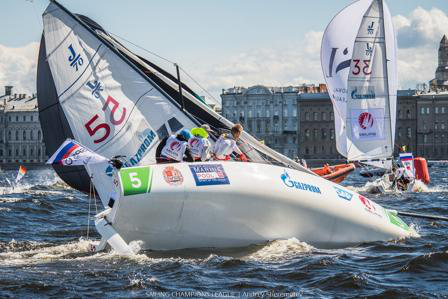

In [4]:
with Image.open(train_path + train_imgs[331]) as im:
    display(im)

In [5]:
def collect_img_sizes(path, image_names):
    img_sizes = []
    rejected_items = []

    for item in image_names:
        try:
            with Image.open(path + item) as img:
                img_sizes.append(img.size)
        except:
            rejected_items.append(item)
    return img_sizes, rejected_items

In [6]:
%%time
train_img_sizes, train_rejected = collect_img_sizes(train_path, train_imgs)
test_img_sizes, test_rejected = collect_img_sizes(test_path, test_imgs)

print(f'Images opened. Train number: {len(train_img_sizes)}. Test number: {len(test_img_sizes)}')
print(f'Images rejected. Train number: {len(train_rejected)}. Test number: {len(test_rejected)}')

Images opened. Train number: 45373. Test number: 19446
Images rejected. Train number: 0. Test number: 0
Wall time: 1min 48s


In [7]:
multi_index = pd.MultiIndex.from_tuples([("train", "width"), ("train", "height")])
df_train = pd.DataFrame(train_img_sizes, columns = multi_index)
df_train[("train", "size_ratio")] = df_train[("train", "width")] / df_train[("train", "height")]

multi_index = pd.MultiIndex.from_tuples([("test", "width"), ("test", "height")])
df_test = pd.DataFrame(test_img_sizes, columns = multi_index)
df_test[("test", "size_ratio")] = df_test[("test", "width")] / df_test[("test", "height")]

size_stats = df_train.describe().T.append(df_test.describe().T).T
size_stats

train                                      test                \
              width        height    size_ratio         width        height   
count  45373.000000  45373.000000  45373.000000  19446.000000  19446.000000   
mean     441.089172    304.801754      1.490591    441.267973    304.757894   
std       30.858708     52.659318      0.265829     30.368564     52.183620   
min       20.000000     20.000000      0.214286     20.000000     20.000000   
25%      448.000000    281.000000      1.464052    448.000000    281.000000   
50%      448.000000    299.000000      1.498328    448.000000    299.000000   
75%      448.000000    306.000000      1.583039    448.000000    307.000000   
max      448.000000    448.000000      5.397590    448.000000    448.000000   

                     
         size_ratio  
count  19446.000000  
mean       1.490225  
std        0.260553  
min        0.395089  
25%        1.459283  
50%        1.498328  
75%        1.583039  
max        5.090909

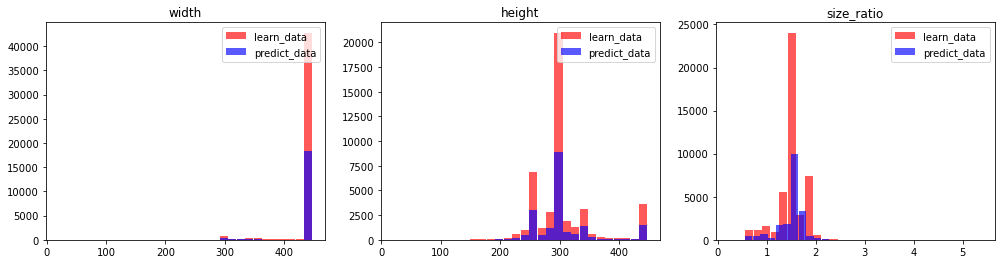

In [8]:
def plot_train_test_hist(data_train, data_test, col_names, col_number=2, figsize_=(18, 8), bins_=10):
    row_numder = -(-len(col_names)//col_number)
    fig, axes_ = plt.subplots(row_numder, col_number, figsize=figsize_)
    
    if (row_numder == 1) or (col_number == 1):
        for counter_ in range(len(col_names)):
            axes_[counter_].hist(data_train[col_names[counter_]], rwidth=0.95,
                                           alpha=0.65, label='learn_data', color='red', bins=bins_)

            axes_[counter_].hist(data_test[col_names[counter_]], rwidth=0.95,
                                           alpha=0.65, label='predict_data', color='blue', bins=bins_)

            axes_[counter_].set_title(col_names[counter_])
            axes_[counter_].legend(loc=1)
    else:
        for counter_ in range(len(col_names)):
            pic_row_ = counter_//col_number
            pic_col_ = counter_ % col_number
            axes_[pic_row_, pic_col_].hist(data_train[col_names[counter_]], rwidth=0.95,
                                           alpha=0.65, label='learn_data', color='red', bins=bins_)

            axes_[pic_row_, pic_col_].hist(data_test[col_names[counter_]], rwidth=0.95,
                                           alpha=0.65, label='predict_data', color='blue', bins=bins_)

            axes_[pic_row_, pic_col_].set_title(col_names[counter_])
            axes_[pic_row_, pic_col_].legend(loc=1)


num_cols = ['width', 'height', 'size_ratio']
plot_train_test_hist(df_train.droplevel(0, axis=1), df_test.droplevel(0, axis=1), 
                     num_cols, col_number=3, figsize_=(17, 4), bins_=30)

In [9]:
train_transform = transforms.Compose([
        transforms.RandomRotation(15),     
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4),
        transforms.RandomGrayscale(p=0.1),    
#         transforms.Resize(256),             
#         transforms.CenterCrop(224),       
        transforms.Resize(size=(299), max_size=(448)),
        transforms.CenterCrop((299, 448)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
#         transforms.Resize(256),             
#         transforms.CenterCrop(224),   
        transforms.Resize(size=(299), max_size=(448)),
        transforms.CenterCrop((299, 448)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 299, 448])


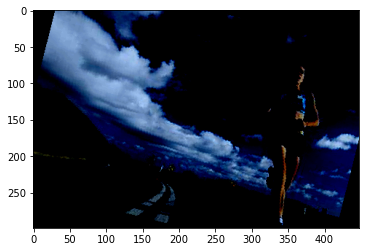

In [10]:
# протестируем train_transform
with Image.open(train_path + train_imgs[15212]) as im:
    im = train_transform(im)
    print(im.shape)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Выводы
- подавляющее большиство изображений имеет ширину в 448 пикселей
- большее количество изображений имеет высоту 299 пикселей
- найденные размеры будут использованы для стандартизации изображений для моделирования

### Подготовка загрузчиков данных

In [11]:
# для самопроверки проверим загрузку изображений по спискам из датасетов
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,image_id,label
0,46514481-2d8b-4d49-8991-012e1bfd34f6.jpeg,swimming
1,ec66e513-adac-4a30-b6a9-3d647ee6e46b.jpeg,greco-Roman_wrestling
2,4d60732e-d680-4bfd-9067-70ff8137f537.jpeg,running
3,93327011-8e3d-4f0d-849d-a26ddaf6488b.jpeg,football
4,b6853478-48c1-48b2-b104-74903730c831.jpeg,sailing


In [12]:
%%time
train_img_paths = df_train["image_id"].apply(lambda x: train_path + x).values
test_img_paths = df_test["image_id"].apply(lambda x: test_path + x).values

train_img_sizes, train_rejected = collect_img_sizes("", train_img_paths)
test_img_sizes, test_rejected = collect_img_sizes("", test_img_paths)

print(f'Images opened. Train number: {len(train_img_sizes)}. Test number: {len(test_img_sizes)}')
print(f'Images rejected. Train number: {len(train_rejected)}. Test number: {len(test_rejected)}')

Images opened. Train number: 45373. Test number: 19446
Images rejected. Train number: 0. Test number: 0
Wall time: 6.18 s


In [13]:
# ClassificationDataset
class ClassificationDataset(Dataset):
    def __init__(self, paths, targets=None, encoder=None, train_state=True):
        self.paths = paths
        if train_state:
            self.data_prepare = train_transform 
            self.targets = targets
            self.enc = encoder        
            self.enc_targets = self.enc.transform(self.targets)
        else:
            self.data_prepare = test_transform
            self.enc_targets = np.zeros(len(paths))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_name = self.paths[idx]
        target = torch.tensor(self.enc_targets[idx], dtype=torch.long)
        with Image.open(img_name) as im:
            image = self.data_prepare(im.convert('RGB'))
        return image, target

In [14]:
# кодировка target
labels = df_train["label"].values;
enc = LabelEncoder();
enc.fit(labels);

In [15]:
train_X_paths, val_X_paths, train_y, val_y = train_test_split(train_img_paths, labels, test_size=VAL_SIZE, random_state=SEED)
train_dataset = ClassificationDataset(train_X_paths, train_y, enc)
val_dataset = ClassificationDataset(val_X_paths, val_y, enc)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Количество классов: {len(enc.classes_)}")
print("Классы:        ", list(enc.classes_))

Количество классов: 30
Классы:         ['alpinism', 'archery', 'arm_wrestling', 'badminton', 'basketball', 'boating', 'boxing', 'fencing', 'football', 'golf', 'greco-Roman_wrestling', 'gymnastics', 'handball', 'hockey', 'horseback_riding', 'javelin-throwing', 'pole_vault', 'rugby', 'running', 'sailing', 'sambo', 'skating', 'ski_race', 'surfing', 'swimming', 'taekwondo', 'tennis', 'velo', 'volleyball', 'water_polo']


### Моделирование (обучение)

In [16]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8} - number of trainable parameters')
    
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [17]:
def train(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs):
    start_time = time.time()

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []
    test_f1_scores = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        # Run the training batches
        model.train()
        for b_, (X_train, y_train) in enumerate(train_loader):
            b = b_ + 1
            y_train = y_train.to(DEVICE)
            X_train = X_train.to(DEVICE)    

            # Apply the model
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print interim results
            if b%140 == 0:
                print(f'\n{i:2} batch: {b:4} loss: {loss.item():5.3f} \
accuracy: {trn_corr.item()*100/(BATCH_SIZE*b):4.1f}% Time: {(time.time() - start_time)/60:.1f} min', end="")

        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # Run the testing batches
        model.eval()
        with torch.no_grad():
            y_test_list = []
            y_pred_list = []
            for b_, (X_test, y_test) in enumerate(val_loader):
                b = b_ + 1
                y_test = y_test.to(DEVICE)
                X_test = X_test.to(DEVICE) 
                # Apply the model
                y_val = model(X_test)

                # Cacl the number of correct predictions
                predicted = torch.max(y_val.data, 1)[1] 
                tst_corr += (predicted == y_test).sum()

                y_test_list.extend(y_test.tolist())
                y_pred_list.extend(predicted.tolist())

        f1_micro = f1_score(y_test_list, y_pred_list, average='micro')
        test_f1_scores.append(f1_micro)
        test_loss = criterion(y_val, y_test)
        test_losses.append(test_loss)
        test_correct.append(tst_corr)
        print(f' TEST: loss: {test_loss.item():5.3f} accuracy: {tst_corr.item()*100/(BATCH_SIZE*b):4.1f}%\
 f1: {f1_micro:5.3f} Time: {(time.time() - start_time)/60:.1f} min')
        print(f'\nLearning Rate: {before_lr:13.11f} -> {after_lr:13.11f}')

    print(f'\nDuration: {(time.time() - start_time) / 60:.1f} min') # print the time elapsed
    
    return train_losses, test_losses

In [27]:
EffNetmodel = models.efficientnet_v2_l(pretrained=True)
for param in EffNetmodel.parameters():
    param.requires_grad = False

EffNetmodel.classifier = nn.Sequential(
                            nn.Dropout(p=0.25),
                            nn.Linear(1280, 640),
                            nn.ReLU(),
                            nn.BatchNorm1d(640, eps=1e-05, momentum=0.1),
                            nn.Dropout(0.25),
                            nn.Linear(640, 320),
                            nn.ReLU(),
                            nn.BatchNorm1d(320, eps=1e-05, momentum=0.1),
                            nn.Dropout(0.25),
                            nn.Linear(320, 30))

In [19]:
count_parameters(EffNetmodel)

  819200
     640
     640
     640
  204800
     320
     320
     320
    9600
      30
________
 1036510 - number of trainable parameters


In [21]:
epochs = 5
EffNetmodel.to(DEVICE)
criterion = nn.CrossEntropyLoss()
model = EffNetmodel
optimizer =  torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.7)

In [22]:
train_losses, test_losses = train(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs)
save_checkpoint('Eff_new_SGD_v0.pt', model, optimizer)


 0 batch:  140 loss: 0.987 accuracy: 56.8% Time: 2.8 min
 0 batch:  280 loss: 0.849 accuracy: 63.6% Time: 5.5 min
 0 batch:  420 loss: 0.911 accuracy: 66.7% Time: 8.2 min
 0 batch:  560 loss: 0.782 accuracy: 68.5% Time: 11.0 min TEST: loss: 0.787 accuracy: 81.6% f1: 0.817 Time: 14.9 min

Learning Rate: 0.01000000000 -> 0.00700000000

 1 batch:  140 loss: 0.778 accuracy: 75.4% Time: 17.6 min
 1 batch:  280 loss: 0.733 accuracy: 75.4% Time: 20.3 min
 1 batch:  420 loss: 0.768 accuracy: 75.9% Time: 23.1 min
 1 batch:  560 loss: 0.769 accuracy: 76.1% Time: 25.8 min TEST: loss: 0.715 accuracy: 83.2% f1: 0.833 Time: 29.2 min

Learning Rate: 0.00700000000 -> 0.00490000000

 2 batch:  140 loss: 0.697 accuracy: 77.1% Time: 31.9 min
 2 batch:  280 loss: 0.922 accuracy: 77.1% Time: 34.6 min
 2 batch:  420 loss: 0.660 accuracy: 77.2% Time: 37.3 min
 2 batch:  560 loss: 0.753 accuracy: 77.3% Time: 40.0 min TEST: loss: 0.655 accuracy: 84.3% f1: 0.844 Time: 43.4 min

Learning Rate: 0.00490000000 -> 

In [24]:
train_losses, test_losses = train(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs)
save_checkpoint('Eff_new_SGD_v1.pt', model, optimizer)


 0 batch:  140 loss: 0.890 accuracy: 79.6% Time: 2.7 min
 0 batch:  280 loss: 0.717 accuracy: 79.7% Time: 5.4 min
 0 batch:  420 loss: 1.081 accuracy: 80.0% Time: 8.1 min
 0 batch:  560 loss: 0.709 accuracy: 79.8% Time: 10.8 min TEST: loss: 0.612 accuracy: 84.5% f1: 0.846 Time: 14.2 min

Learning Rate: 0.00168070000 -> 0.00117649000

 1 batch:  140 loss: 0.629 accuracy: 80.2% Time: 16.9 min
 1 batch:  280 loss: 0.654 accuracy: 80.3% Time: 19.6 min
 1 batch:  420 loss: 0.968 accuracy: 80.5% Time: 22.3 min
 1 batch:  560 loss: 0.676 accuracy: 80.6% Time: 25.1 min TEST: loss: 0.653 accuracy: 85.3% f1: 0.854 Time: 28.5 min

Learning Rate: 0.00117649000 -> 0.00082354300

 2 batch:  140 loss: 0.804 accuracy: 81.2% Time: 31.2 min
 2 batch:  280 loss: 0.637 accuracy: 81.1% Time: 33.9 min
 2 batch:  420 loss: 0.733 accuracy: 81.1% Time: 36.6 min
 2 batch:  560 loss: 0.513 accuracy: 81.0% Time: 39.3 min TEST: loss: 0.569 accuracy: 86.7% f1: 0.868 Time: 42.7 min

Learning Rate: 0.00082354300 -> 

In [26]:
train_losses, test_losses = train(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs)
save_checkpoint('Eff_new_SGD_v2.pt', model, optimizer)


 0 batch:  140 loss: 0.712 accuracy: 82.4% Time: 2.7 min
 0 batch:  280 loss: 0.921 accuracy: 82.3% Time: 5.4 min
 0 batch:  420 loss: 0.597 accuracy: 82.1% Time: 8.2 min
 0 batch:  560 loss: 0.800 accuracy: 82.1% Time: 10.9 min TEST: loss: 0.583 accuracy: 86.6% f1: 0.867 Time: 14.4 min

Learning Rate: 0.00028247525 -> 0.00019773267

 1 batch:  140 loss: 0.611 accuracy: 82.2% Time: 17.1 min
 1 batch:  280 loss: 0.714 accuracy: 82.2% Time: 19.8 min
 1 batch:  420 loss: 0.844 accuracy: 82.2% Time: 22.5 min
 1 batch:  560 loss: 0.585 accuracy: 82.2% Time: 25.2 min TEST: loss: 0.519 accuracy: 88.3% f1: 0.885 Time: 28.6 min

Learning Rate: 0.00019773267 -> 0.00013841287

 2 batch:  140 loss: 0.852 accuracy: 82.1% Time: 31.3 min
 2 batch:  280 loss: 0.627 accuracy: 81.9% Time: 34.0 min
 2 batch:  420 loss: 0.637 accuracy: 82.1% Time: 36.7 min
 2 batch:  560 loss: 0.600 accuracy: 82.0% Time: 39.4 min TEST: loss: 0.382 accuracy: 87.6% f1: 0.877 Time: 42.8 min

Learning Rate: 0.00013841287 -> 

### Прогноз

In [28]:
%%time
pred_dataset = ClassificationDataset(test_img_paths, train_state=False)
pred_loader = DataLoader(pred_dataset, batch_size=BATCH_SIZE, shuffle=False)
model.eval()
result = []
with torch.no_grad():
    for b, (X_pred, y_pred) in enumerate(pred_loader):
        X_pred = X_pred.to(DEVICE) 
        y_pred = model(X_pred)       
        new_pred = torch.max(y_pred.data, 1)[1]         
        result.extend(enc.inverse_transform(new_pred.to("cpu").numpy()).tolist())
        
df_test['label'] = result
sub_name = "submission_eff_net_v6.csv"
df_test.to_csv(sub_name,index=False)
print(f"Submission ready: {sub_name}")

Submission ready: submission_eff_net_v6.csv
Wall time: 6min 54s
